**Challenge context**

Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).

**Challenge goals**

L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

**Data description**
* Index
>* DELIVERY_START : date et heure de livraison de l'électricité

* Variables explicatives
>* load_forecast : prévision de consommation totale d'éléctricité en France
>* coal_power_available, gas_power_available, nucelear_power_available : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
>* wind_power_forecasts_average, solar_power_forecasts_average : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
>* wind_power_forecasts_std, solar_power_forecasts_std : écart-type de ces mêmes prévisions,
>* predicted_spot_price : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

* Variable cible
>* spot_id_delta : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

**Métrique d'évaluation des performances du modèle**

Puisque l'objectif est avant de tout de prédire correctement le sens de l'écart, on s'appuyera sur une métrique de classification pour évaluer la performance d'un modèle. La grandeur de l'écart observé nous importe aussi : plus l'écart observé est important, plus il est important de prédire le correctement son sens. La métrique de performance proposée pour ce challenge est donc la Weighted Accuracy. C'est à dire la proprotion des predictions dont les sens (positif ou négatif) est correctement identifié pondérée par la valeur absolue des écarts réellement observés

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


C:\Users\TRETEC\AppData\Local\Temp\ipykernel_20892\2789279257.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
x_train = pd.read_csv("x_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv("y_train.csv", index_col= 'DELIVERY_START', parse_dates=True)

x_test = pd.read_csv("x_test.csv", index_col= 'DELIVERY_START', parse_dates=True)

In [7]:
x_train.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [5]:
y_train.head()

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-36.874770
2022-01-01 03:00:00+01:00,-12.643588
2022-01-01 04:00:00+01:00,-1.950193
2022-01-01 05:00:00+01:00,1.938272
2022-01-01 06:00:00+01:00,0.199907


In [6]:
print(f"Training data : from {x_train.index.min().date()} to {x_train.index.max().date()}")
print(f"Test data : from {x_test.index.min().date()} to {x_test.index.max().date()}")

Training data : from 2022-01-01 to 2023-03-29
Test data : from 2023-04-02 to 2023-10-24


In [8]:
x_train.shape

(10605, 9)

In [9]:
x_test.shape

(4942, 9)

<Axes: ylabel='DELIVERY_START'>

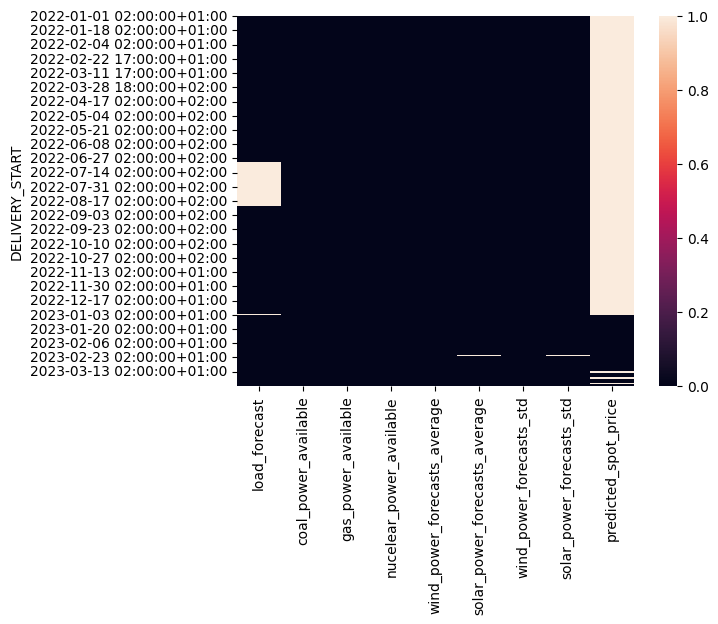

In [10]:
sns.heatmap(x_train.isna())

<Axes: ylabel='DELIVERY_START'>

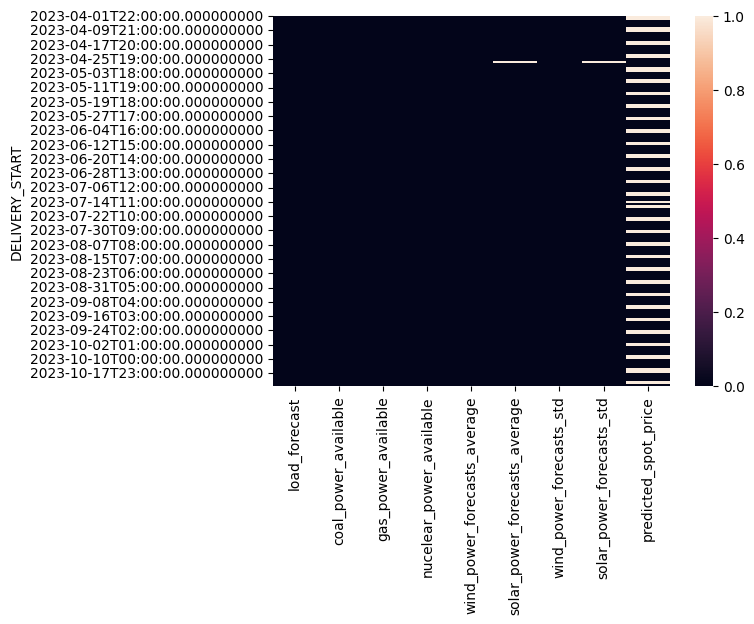

In [11]:
sns.heatmap(x_test.isna())

In [57]:
#binariser y_train
y_train_cls = X_binarized = np.where(y_train > 0, 1, -1)
y_train_cls

array([[-1],
       [-1],
       [-1],
       ...,
       [ 1],
       [ 1],
       [ 1]])

In [38]:
x_train.drop(columns=['predicted_spot_price'], inplace=True)
x_test.drop(columns=['predicted_spot_price'], inplace=True)

In [42]:
from sklearn.preprocessing import RobustScaler

# Create an instance of RobustScaler
scaler = RobustScaler()

# Fit the scaler to your data and transform it
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# To dataframes
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# index
x_train_scaled.set_index(x_train.index, inplace=True)
x_test_scaled.set_index(x_test.index, inplace=True)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have your features in X and labels in y

# Create a Random Forest Classifier instance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(x_train_scaled, y_train_cls)

# Predict on the testing data
y_pred = rf_classifier.predict(x_test_scaled)


c:\Users\TRETEC\Documents\MVA\S2\[Mallat]\data_challenge_elmy\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [86]:
submission = pd.DataFrame(y_pred, columns=['spot_id_delta'])

In [88]:
submission

,spot_id_delta
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
4937,-1
4938,-1
4939,-1
4940,-1


In [90]:
submission['DELIVERY_START'] = x_test.index

<Axes: >

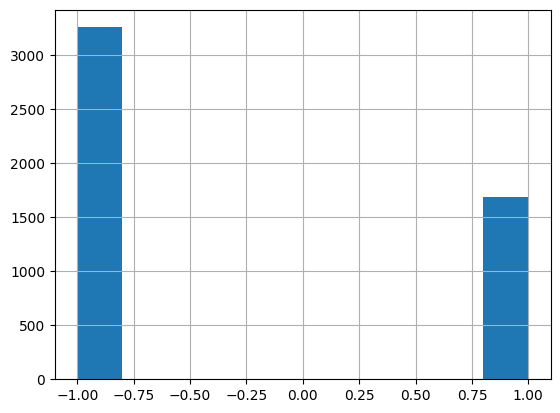

In [91]:
submission['spot_id_delta'].hist()

In [80]:
submission.to_csv('submission.csv')